In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import kdsource.surfsource as kds
from typing import Sequence, Tuple, List, Optional


def _weighted_cdf(x: np.ndarray,
                  edges: np.ndarray,
                  w: Optional[np.ndarray] = None
                  ) -> Tuple[np.ndarray, np.ndarray]:
    """
    CDF por pasos para `x` en los puntos `edges`.

    Parameters
    ----------
    x : ndarray
        Datos (letargia).
    edges : ndarray
        Bordes del histograma donde evaluar la CDF (monótonos).
    w : ndarray, optional
        Pesos por evento (misma longitud que `x`). None → todos 1.

    Returns
    -------
    edges : ndarray
        Copia de `edges` (conveniencia para el plot).
    cdf   : ndarray
        CDF normalizada (0 → 1) evaluada en `edges`.
    """
    counts, _ = np.histogram(x, bins=edges, weights=w)
    cdf = np.insert(np.cumsum(counts), 0, 0)        # Prepend 0
    cdf = cdf / cdf[-1] if cdf[-1] else cdf         # Normaliza
    return edges, cdf


# ---------------------------------------------------------------------------
# 1)  nuevo ALGORITMO ITERATIVO  (inserta bordes uno a uno)
# ---------------------------------------------------------------------------
def adaptive_macro_edges_iterative(
    x: np.ndarray,
    *,
    initial_bins: int = 6,
    extra_edges: int = 3,
    fine_bins: int = 1000,
    w: Optional[np.ndarray] = None,
    min_sep: float = 1e-6,
) -> Tuple[np.ndarray, List[np.ndarray], np.ndarray]:
    """
    Devuelve:
        edges  – bordes finales               (ndarray)
        diffs  – lista |ΔCDF| en cada paso    (list[np.ndarray])
        fine_x – abscisas de esas curvas      (ndarray)
    """
    x_min, x_max = float(x.min()), float(x.max())
    edges = np.linspace(x_min, x_max, initial_bins + 1)

    fine_edges = np.linspace(x_min, x_max, fine_bins + 1)
    _, cdf_fine = _weighted_cdf(x, fine_edges, w)
    fine_centers = 0.5 * (fine_edges[:-1] + fine_edges[1:])

    diffs: List[np.ndarray] = []

    for _ in range(extra_edges):
        # CDF coarse y error actual
        _, cdf_coarse = _weighted_cdf(x, edges, w)
        cdf_coarse_interp = np.interp(fine_edges, edges, cdf_coarse)
        diff = np.abs(cdf_fine - cdf_coarse_interp)
        diffs.append(diff[:-1].copy())

        # máximo |ΔCDF| que respete min_sep
        for idx in np.argsort(diff[:-1])[::-1]:
            cand = fine_centers[idx]
            if (np.abs(cand - edges) > min_sep).all():
                edges = np.sort(np.append(edges, cand))
                break

    return edges, diffs, fine_edges[:-1]   # fine_edges[:-1] ↔ diff


# ---------------------------------------------------------------------------
# 2)  plot de la EVOLUCIÓN del error
# ---------------------------------------------------------------------------
def plot_cdf_error_evolution(
    diffs: Sequence[np.ndarray],
    fine_x: np.ndarray,
    *,
    overlay: bool = False,
    ax: Optional[plt.Axes] = None,
) -> None:
    """
    Si overlay=False (default) dibuja un subplot por iteración;
    si overlay=True superpone todas las curvas en un mismo eje.
    """
    n = len(diffs)
    if overlay:
        ax = ax or plt.gca()
        for k, d in enumerate(diffs, 1):
            ax.plot(fine_x, d, label=f"iter {k}")
        ax.set_xlabel(r"$\ln(E_0/E)$")
        ax.set_ylabel(r"$|\,\Delta\mathrm{CDF}\,|$")
        ax.legend();  ax.grid(ls=":");  plt.tight_layout()
    else:
        fig, axs = plt.subplots(n, 1, figsize=(5, 1.6*n), sharex=True)
        if n == 1:   axs = [axs]
        for ax_, d, k in zip(axs, diffs, range(1, n+1)):
            ax_.plot(fine_x, d);  ax_.set_ylabel(f"iter {k}");  ax_.grid(ls=":")
        axs[-1].set_xlabel(r"$\ln(E_0/E)$");  fig.supylabel(r"$|\,\Delta\mathrm{CDF}\,|$")
        fig.tight_layout()


def plot_cdf_comparison(x: np.ndarray,
                        *,
                        edges6: Sequence[float],
                        edges9: Sequence[float],
                        fine_bins: int = 1000,
                        w: Optional[np.ndarray] = None,
                        ax: Optional[plt.Axes] = None
                        ) -> None:
    """
    Dibuja las CDFs: fina, 6 bins y 9 bins.

    Parameters
    ----------
    x : ndarray
        Variable letargia.
    edges6 : array-like
        Bordes del esquema inicial (6 bins).
    edges9 : array-like
        Bordes del esquema mejorado (9 bins).
    fine_bins : int, default 1000
        Nº de bins para la CDF de referencia.
    w : ndarray, optional
        Pesos.
    ax : matplotlib.Axes, optional
        Dónde dibujar; None → crea figura nueva.
    """
    ax = ax or plt.gca()

    # CDF fina
    fine_edges = np.linspace(x.min(), x.max(), fine_bins + 1)
    x_fine, cdf_fine = _weighted_cdf(x, fine_edges, w)
    ax.step(x_fine, cdf_fine, where="post", label="CDF 1000 bins", lw=2, color="C0")

    # CDF 6 bins
    x6, cdf6 = _weighted_cdf(x, np.asarray(edges6), w)
    ax.step(x6, cdf6, where="post", label="CDF 6 bins", lw=1.5, color="C1")

    # CDF 9 bins
    x9, cdf9 = _weighted_cdf(x, np.asarray(edges9), w)
    ax.step(x9, cdf9, where="post", label="CDF 9 bins", lw=1.5, color="C3")

    ax.set_xlabel(r"$\ln(E_0/E)$ (letargia)")
    ax.set_ylabel("CDF")
    ax.legend()
    ax.grid(True, ls=":")
    plt.tight_layout()

def plot_hist_with_edges(
    x: np.ndarray,
    edges: Sequence[float],
    *,
    bins: int | Sequence[float] = 200,
    w: Optional[np.ndarray] = None,
    ax: Optional[plt.Axes] = None,
    histtype: str = "step",
    show_stats: bool = True,
    return_stats: bool = False,
    **kwargs,
) -> Tuple[np.ndarray, np.ndarray, Optional[pd.DataFrame]]:
    """
    Muestra la distribución de ``x`` (escala y log) y las líneas verticales
    correspondientes a los bordes *macro*.  Además imprime un resumen con el
    % de partículas y el % de peso por macro-bin.

    Parameters
    ----------
    x : ndarray
        Datos (p. ej. letargia).
    edges : array-like
        Bordes finales de los macrogrupos (ordenados, longitud ≥ 2).
    bins : int | array-like, default 200
        Esquema de binning para el histograma de la PDF.
    w : ndarray, optional
        Pesos por evento. ``None`` → todos 1.
    ax : matplotlib.Axes, optional
        Eje donde dibujar.
    histtype : {'step', 'bar'}, default 'step'
        Estilo del histograma.
    show_stats : bool, default True
        Imprime la tabla de porcentajes en pantalla.
    return_stats : bool, default False
        Devuelve el DataFrame con las estadísticas si es ``True``.
    **kwargs :
        Argumentos extra para ``plt.hist``.

    Returns
    -------
    hist : ndarray
        Cuentas normalizadas del histograma de la PDF.
    bin_edges : ndarray
        Bordes utilizados para el histograma.
    stats_df : pandas.DataFrame | None
        Resumen por macro-grupo (sólo si ``return_stats=True``).
    """
    ax = ax or plt.gca()

    # --- 1) Histograma de la PDF --------------------------------------------
    hist, bin_edges, _ = ax.hist(
        x,
        bins=bins,
        weights=w,
        histtype=histtype,
        density=True,
        **kwargs,
    )
    ax.set_yscale("log")
    ax.set_xlabel(r"$\ln(E_0/E)$")
    ax.set_ylabel("PDF normalizada")
    ax.grid(ls=":", which="both")

    for e in edges:
        ax.axvline(e, ls="--", lw=1.0, color="k", alpha=0.7)

    plt.tight_layout()

    # --- 2) Estadísticas por macro-grupo ------------------------------------
    #   counts_p  → nº de partículas por macro-bin
    #   counts_w  → suma de pesos   por macro-bin
    counts_p, _ = np.histogram(x, bins=edges)
    if w is None:
        counts_w = counts_p.astype(float)       #  peso = 1
    else:
        counts_w, _ = np.histogram(x, bins=edges, weights=w)

    tot_p = counts_p.sum()
    tot_w = counts_w.sum()
    perc_p = 100 * counts_p / tot_p if tot_p else np.zeros_like(counts_p)
    perc_w = 100 * counts_w / tot_w if tot_w else np.zeros_like(counts_w)

    stats_df = pd.DataFrame({
        "E_min": edges[:-1],
        "E_max": edges[1:],
        "N_particles": counts_p,
        "% particles": perc_p,
        "Weight_sum": counts_w,
        "% weight": perc_w,
    })

    if show_stats:
        print("\n┌────────────────────  Resumen por macro-grupo  ────────────────────┐")
        print(stats_df.to_string(index=False, formatters={
            "% particles": "{:.2f}".format,
            "% weight":    "{:.2f}".format,
        }))
        print("└────────────────────────────────────────────────────────────────────┘\n")

    return (hist, bin_edges, stats_df if return_stats else None)

Number of particles in file /home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/ssf_N17b_C5_trf.h5: 45840
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Bordes 6 bins: [ 0.38764702 23.61868157]
Bordes 9 bins: [ 0.38764702  0.85226771  1.02650047  1.3168884   1.65373841  1.7815091
  2.09512806  2.24612979  2.51328668  2.71075048  2.95467634  3.17537117
  3.396066    3.63999186  4.10461255  4.56923324  4.743466    4.99900738
  5.03385393  5.30101083  5.49847462  5.96309531  6.427716    6.89233669
  7.35695739  7.82157808  8.28619877  8.75081946  9.21544015  9.68006084
 10.14468153 10.60930222 11.07392291 11.5385436  12.00316429 12.46778499
 12.93240568 13.39702637 13.86164706 14.32626775 14.79088844 15.25550913
 15.72012982 16.18475051 16.6493712  17.11399189 17.35791776 17.57861258
 18.04323328 18.33362121 18.44977638 18.50785397 18.63562466 18.68208673
 18.77501086 18.84470397 18.91439707 18.97247466 19.03055224 19.07701431
 19.12347638 19.19316949 19.23963155 19.33255569 19.43709535 19.495172

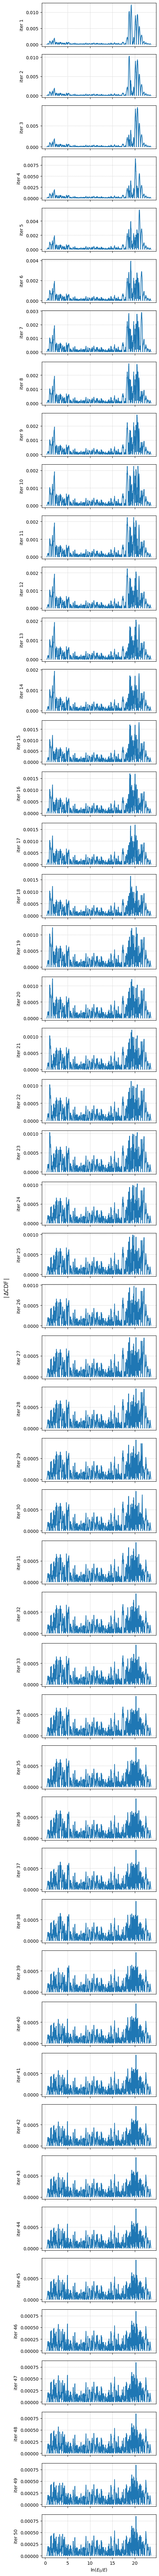

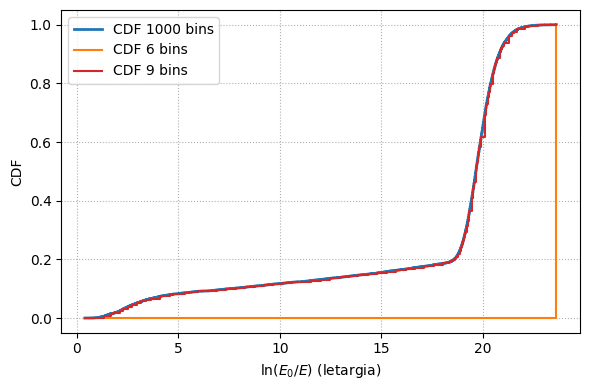

In [5]:
# --- 1) LECTURA --------------------------------------------------------------
df = kds.SurfaceSourceFile(
    "/home/lucas/Documents/Proyecto_Integrador/PI/conductoN5/ssf_N17b_C5_trf.h5",
    domain={"w": [0, 2]},
).get_pandas_dataframe()[["x", "y", "ln(E0/E)", "mu", "phi", "wgt"]]

letargia = df["ln(E0/E)"].to_numpy()
pesos    = df["wgt"].to_numpy()

# --- 2) BORDES ---------------------------------------------------------------
#   6 bins “base”  → pide extra_edges=0
edges6, _, _ = adaptive_macro_edges_iterative(
    letargia,
    initial_bins=1,
    extra_edges=0,
    w=pesos,
)

#   9 bins = 6 + 3 nuevos
edges9, diffs, fine_x = adaptive_macro_edges_iterative(
    letargia,
    initial_bins=50,
    extra_edges=50,
    w=pesos,
)

print("Bordes 6 bins:", edges6)
print("Bordes 9 bins:", edges9)

# --- 3) CURVA DE ERROR -------------------------------------------------------
plot_cdf_error_evolution(diffs, fine_x, overlay=False)   # o overlay=True
plt.show()

# --- 4) CDF COMPARISON -------------------------------------------------------
plt.figure(figsize=(6, 4))
plot_cdf_comparison(letargia, edges6=edges6, edges9=edges9, w=pesos)
plt.show()



┌────────────────────  Resumen por macro-grupo  ────────────────────┐
    E_min     E_max  N_particles % particles  Weight_sum % weight
 0.387647  0.852268           18        0.04   13.365551     0.06
 0.852268  1.026500           30        0.07   24.684187     0.11
 1.026500  1.316888          111        0.27  100.192384     0.45
 1.316888  1.653738          206        0.50  192.204440     0.87
 1.653738  1.781509           38        0.09   34.970083     0.16
 1.781509  2.095128          169        0.41  159.859452     0.72
 2.095128  2.246130          144        0.35  140.138186     0.63
 2.246130  2.513287          217        0.53  207.786124     0.94
 2.513287  2.710750          127        0.31  122.260490     0.55
 2.710750  2.954676          159        0.39  152.727626     0.69
 2.954676  3.175371          119        0.29  115.102967     0.52
 3.175371  3.396066          116        0.28  113.134194     0.51
 3.396066  3.639992          104        0.25   99.597228     0.45
 3.63

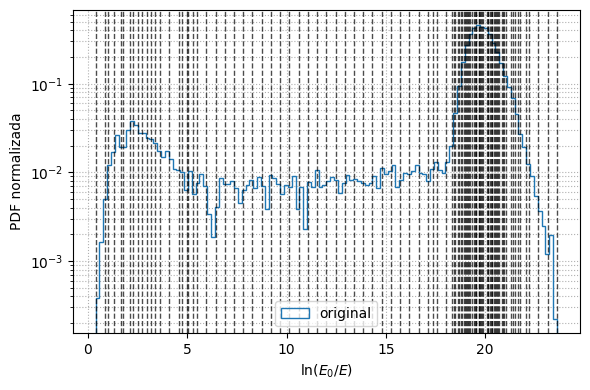

In [6]:
plt.figure(figsize=(6,4))
plot_hist_with_edges(
    letargia,
    edges9,           # borde final
    bins=120,
    w=pesos,
    color="C0",
    label="original"
)
plt.legend()
plt.show()